# TASK A: Image Retrieval with Pre-Trained Image Classification Model

In [128]:
import os
import cv2
import torch
import torchvision


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
import torchvision.transforms as transforms

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, label_binarize
from cf_matrix import *

Initialize Image DataLoader 

In [108]:
DATASET = '../../MIT_split'
BATCH_SIZE = 1
CLASSES = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding']

# Dataset Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Folders
train_dataset = torchvision.datasets.ImageFolder(os.path.join(DATASET,'train'), transform=transform)
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DATASET,'test'), transform=transform)

# Paths map(list, zip(*lot))
train_images, train_labels = map(list, zip(*[(path, label) for path, label in train_dataset.imgs]))
test_images, test_labels = map(list, zip(*[(path, label) for path, label in test_dataset.imgs]))

# Load Images
train_images = np.array([cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in tqdm(train_images)])
test_images = np.array([cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in tqdm(test_images)])

# Images shape
print(f"Train Images : {train_images.shape}")
print(f"Test Images : {test_images.shape}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 807/807 [00:03<00:00, 266.80it/s]


Train Images : (1881, 256, 256, 3)
Test Images : (807, 256, 256, 3)


### Retrieval with KNN

First we load the data, apply some normalization and apply dim. reduction.

In [109]:
# Load Saved Features
train_features = pkl.load(open("../features/train_features_resnet50.pkl", "rb"))
test_features = pkl.load(open("../features/test_features_resnet50.pkl", "rb"))
# Flatten List
train_features = np.array([item for sublist in train_features for item in sublist]).reshape((1881, 2048))
test_features = np.array([item for sublist in test_features for item in sublist]).reshape((807, 2048))

# Normalize
normalizer = StandardScaler() # Normalize Data
train_features = normalizer.fit_transform(train_features)
test_features = normalizer.transform(test_features)

# Dim Before Reduction
print(f"Train Dim Before Reduction : {train_features.shape}")
print(f"Test Dim Before Reduction : {test_features.shape}")

# Dim Reduction
pca = PCA(n_components=0.95) # Keep 95% Variance
train_features = pca.fit_transform (train_features)
test_features = pca.transform (test_features)

print("---"*15)

# Dim After Reduction
print(f"Train Dim After Reduction : {train_features.shape}")
print(f"Test Dim After Reduction : {test_features.shape}")


Train Dim Before Reduction : (1881, 2048)
Test Dim Before Reduction : (807, 2048)
---------------------------------------------
Train Dim After Reduction : (1881, 372)
Test Dim After Reduction : (807, 372)


Then we train a NearestNeighbor to get similar images

In [110]:
k = 10
if not os.path.exists("../models/knn_model.pkl"):
    model = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(train_features)
    pkl.dump(model, open("../models/knn_model.pkl", "wb"))
else:
    model = pkl.load(open("../models/knn_model.pkl", "rb"))

In [111]:
def retrieve_top_k(model, query, k):
    distances,indices = model.kneighbors(query.reshape((1, train_features.shape[1])))
    top, labels = map(list, zip(*[(train_images[indices[0][i]], train_labels[indices[0][i]]) for i in range(k)]))
    return (top, labels)

# Plot top K and query
def plot_top_3(query, top):
    fig, axs = plt.subplots(2, 2, figsize=(15,15))
    axs[0, 0].imshow(query[0])
    axs[0, 0].set_title(f'Query Image || Class: {query[1]}')
    axs[0, 0].axis('off')
    axs[0, 1].imshow(top[0][0])
    axs[0, 1].set_title(f'Top 1 || Class: {top[1][0]}')
    axs[0, 1].axis('off')
    axs[1, 0].imshow(top[0][1])
    axs[1, 0].set_title(f'Top 2 || Class: {top[1][1]}')
    axs[1, 0].axis('off')
    axs[1, 1].imshow(top[0][2])
    axs[1, 1].set_title(f'Top 3 || Class: {top[1][2]}')
    axs[1, 1].axis('off')
    plt.axis("off")
    plt.show()

Evaluating with Train Data

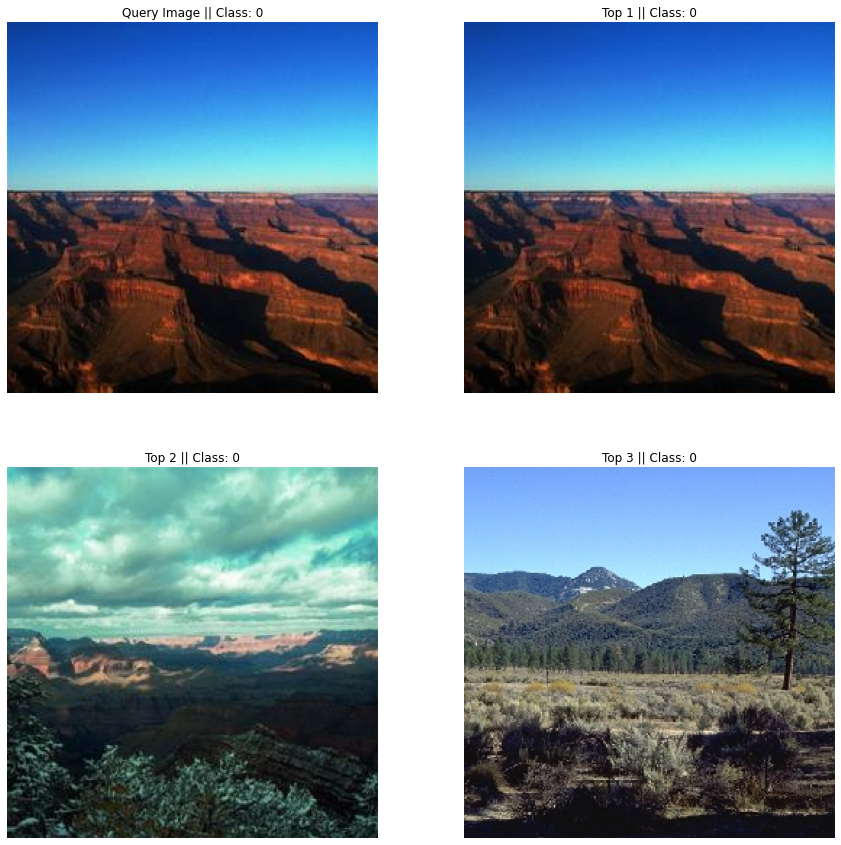

In [112]:
top = retrieve_top_k(model = model, query = train_features[5], k = 10)
plot_top_3((train_images[5], train_labels[5]), top)

Evaluating with Test Data

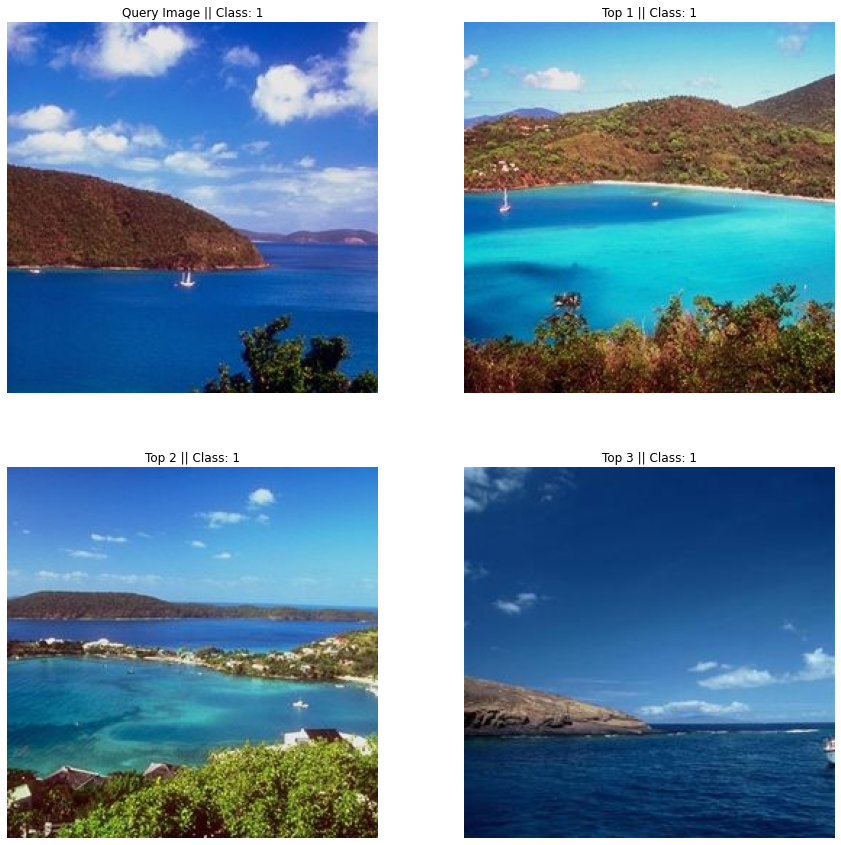

In [113]:
top = retrieve_top_k(model = model, query = test_features[150], k = 10)
plot_top_3((test_images[150], test_labels[150]), top)

Now some Metrics. [Confusion Matrix code from here](https://github.com/DTrimarchi10/confusion_matrix)

In [164]:
def evaluate_ap(data, labels, k):
    # Predict
    predicted = np.array([retrieve_top_k(model = model, query = query, k = k)[1][:k] for query, classes in zip(data, labels)])
    real = np.array([[labels[i] for _ in range(k)] for i in range(len(data))])
    
    # Encode
    encoder = OneHotEncoder()
    real = encoder.fit_transform(real).toarray()
    predicted = encoder.transform(predicted).toarray()
    
    # Metrics
    ap = average_precision_score(predicted, real)
    
    #Info
    print(f"AP@k={k}: {ap:.4f}")
    

def evaluate_precision_recall(data, labels, k):
    # Predict
    predicted = np.array([retrieve_top_k(model = model, query = query, k = k)[1][:k] for query, classes in zip(data, labels)])
    real = np.array([[labels[i] for _ in range(k)] for i in range(len(data))])
    
    # Encode
    encoder = OneHotEncoder()
    real = encoder.fit_transform(real).toarray()
    predicted = encoder.transform(predicted).toarray()
    
    # precision recall curve
    precision = dict()
    recall = dict()
    for i in range(8):
        precision[i], recall[i], _ = precision_recall_curve(real[:, i], predicted[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title(f"precision vs. recall curve @k={k}")
    plt.show()

    
def evaluate_cm(data, labels, k):
    # Predict
    predicted = np.array([retrieve_top_k(model = model, query = query, k = k)[1][:k] for query, classes in zip(data, labels)])
    real = np.array([[labels[i] for _ in range(k)] for i in range(len(data))])
    
    # Confusion Matrix
    cf_matrix = confusion_matrix([[item] for sublist in real for item in sublist],
                                 [[item] for sublist in predicted for item in sublist])
    # Encode
    encoder = OneHotEncoder()
    real = encoder.fit_transform(real).toarray()
    predicted = encoder.transform(predicted).toarray()
    
    make_confusion_matrix(cf_matrix, figsize=(8,6), cbar=False)
    plt.title(f"Confusion Matrix @k={k}")
    plt.show()


Average Precision with k = 1, 3, 5, 10 in Test

In [165]:
evaluate_ap(test_features, test_labels, k=1)
evaluate_ap(test_features, test_labels, k=3)
evaluate_ap(test_features, test_labels, k=5)
evaluate_ap(test_features, test_labels, k=10)

AP@k=1: 0.8117
AP@k=3: 0.7759
AP@k=5: 0.7658
AP@k=10: 0.7433


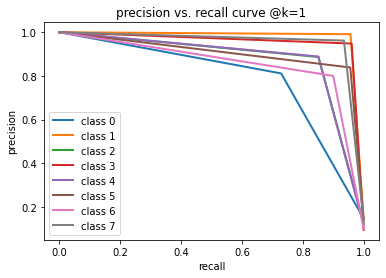

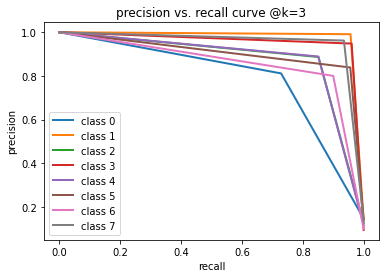

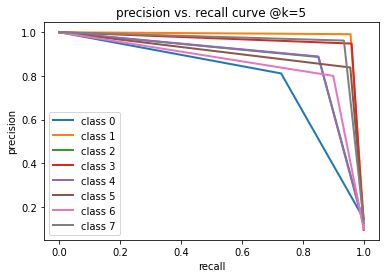

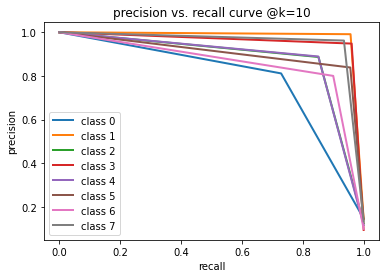

In [166]:
evaluate_precision_recall(test_features, test_labels, k=1)
evaluate_precision_recall(test_features, test_labels, k=3)
evaluate_precision_recall(test_features, test_labels, k=5)
evaluate_precision_recall(test_features, test_labels, k=10)

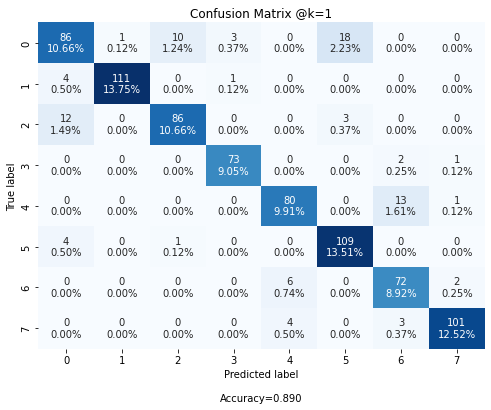

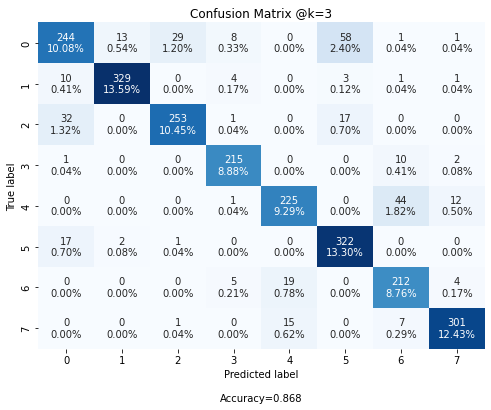

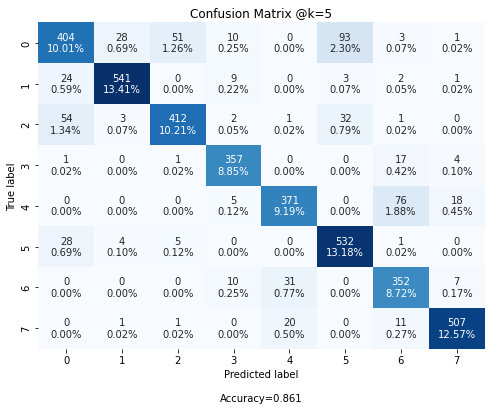

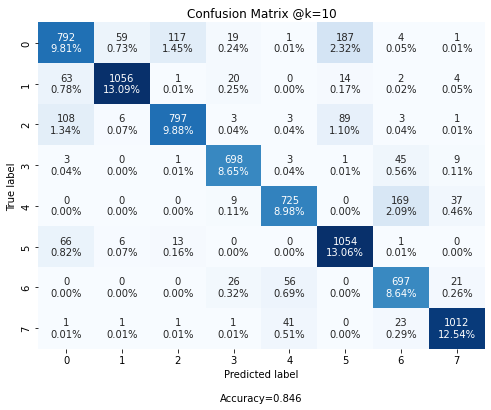

In [167]:
evaluate_cm(test_features, test_labels, k=1)
evaluate_cm(test_features, test_labels, k=3)
evaluate_cm(test_features, test_labels, k=5)
evaluate_cm(test_features, test_labels, k=10)